# DenseNet3D

En este notebook modificaré la arquitectura de la anterior DenseNet2d con aumento de datos (mejor resultado hasta el momento) y lo adaptaré para tratar realmente imagen 3D, no imagen 2D de 64 canales.

In [12]:
!pip install medmnist --quiet
#!pip install --upgrade tensorflow --quiet
!pip install --upgrade keras_tuner --quiet
#!pip install --upgrade keras --quiet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [13]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import numpy as np
import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; import keras_tuner; from keras import layers
keras.utils.set_random_seed(23)

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
np.set_printoptions(precision=2)
def print_cm(model):
    y_pred = model.predict(X_test).argmax(axis = 1)
    y_true = y_test.argmax(axis = 1)

    disp = ConfusionMatrixDisplay.from_predictions(
          y_true,
          y_pred,
          display_labels=labels,
          cmap=plt.cm.Blues,
          normalize="true",
      )
    disp.ax_.set_title("Confusion Matrix")
    fig = disp.ax_.get_figure()
    fig.set_figwidth(15)
    fig.set_figheight(15)

    disp = ConfusionMatrixDisplay.from_predictions(
          y_true,
          y_pred,
          display_labels=labels,
          cmap=plt.cm.Reds,
          normalize="pred",
      )
    disp.ax_.set_title("Confusion Matrix")
    fig = disp.ax_.get_figure()
    fig.set_figwidth(15)
    fig.set_figheight(15)

In [54]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size = 64)
val_dataset = DataClass(split='val', download=download, size = 64)
test_dataset = DataClass(split='test', download=download, size = 64)


train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d_64.npz


In [55]:
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(971, 64, 64, 64) (971, 1) (610, 64, 64, 64) (610, 1)


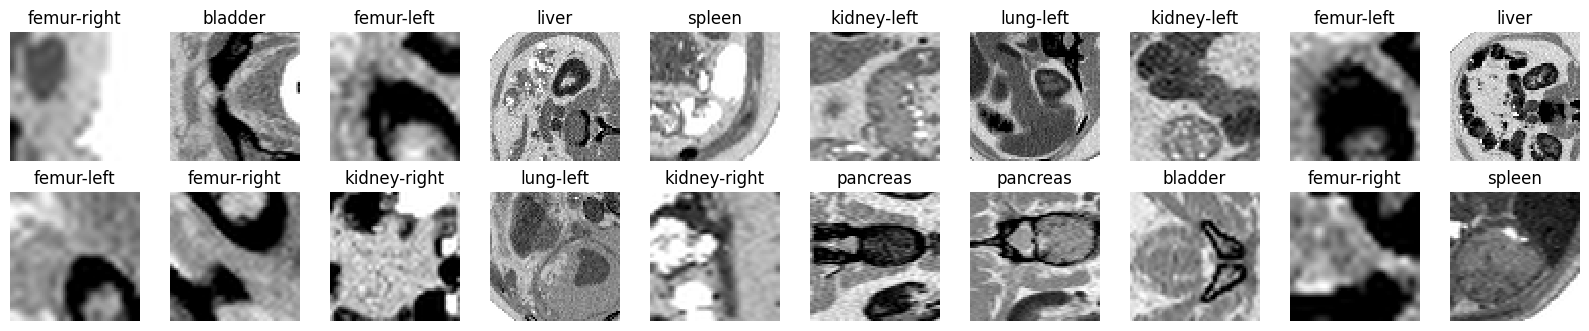

In [56]:
import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
  ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
  ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")

In [57]:
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
input_shape = X_train[0].shape
input_shape

(971, 64, 64, 64) (971, 11) (610, 64, 64, 64) (610, 11)


(64, 64, 64)

# DenseNet

## 3D 

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool3D, GlobalAveragePooling3D, MaxPool3D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

Using downloaded and verified file: /root/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d_64.npz
(971, 64, 64, 64) (971, 1) (610, 64, 64, 64) (610, 1)
(971, 64, 64, 64) (971, 11) (610, 64, 64, 64) (610, 11)


(64, 64, 64)

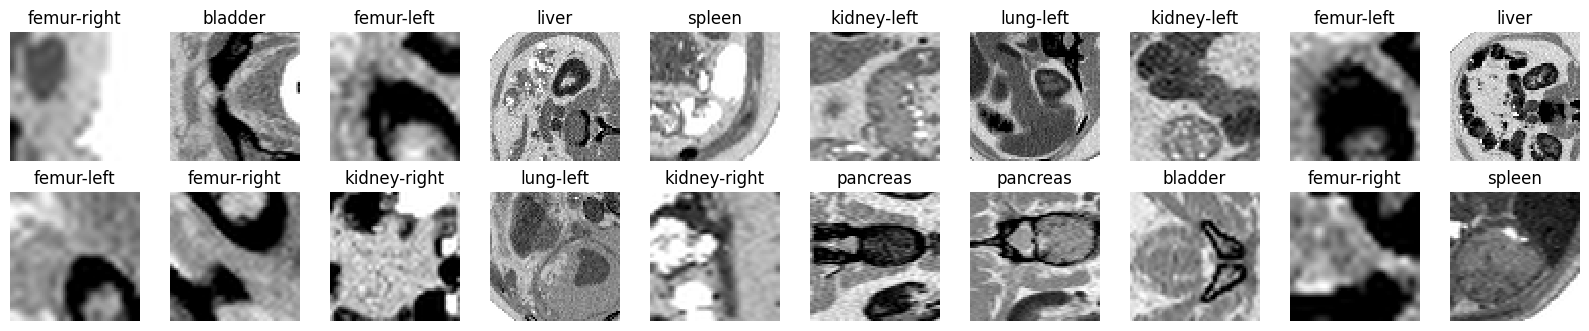

In [16]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size = 64)
val_dataset = DataClass(split='val', download=download, size = 64)
test_dataset = DataClass(split='test', download=download, size = 64)

import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
    ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
    
    
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
input_shape = X_train[0].shape
input_shape

In [17]:
filters = 32
class MyHyperModel():
    def bn_rl_conv(self,x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv3D(filters, kernel, strides=strides, padding = 'same')(x)
        return x
    
    def dense_block(self,x, repetition):
        for _ in range(repetition):
            y = self.bn_rl_conv(x, 4*filters)
            y = self.bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(self,x):
        x = self.bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool3D(2, strides = 2, padding = 'same')(x)
        return x

    def build(self):
        inputs = Input(input_shape)
        factor = 0.2
        inputs = keras.layers.RandomRotation(factor, fill_mode="nearest")(inputs)
        inputs = keras.layers.RandomTranslation(factor, factor, fill_mode="nearest")(inputs)
        inputs = keras.layers.RandomZoom(factor, fill_mode="nearest")(inputs)
        x = keras.layers.Rescaling(1./(255/2) -1)(inputs)
        x = keras.layers.Reshape((x.shape[1], x.shape[2], x.shape[3], 1))(x)
        
        x = Conv3D(64, 7, strides = 2, padding = 'same')(x)
        x = MaxPool3D(3, strides = 2, padding = 'same')(x)

        for repetition in [6,12,24,16]:
            d = self.dense_block(x, repetition)
            x = self.transition_layer(d)

        x = GlobalAveragePooling3D()(d)
        outputs = Dense(num_classes, activation = 'softmax')(x)

        model = Model(inputs, outputs)
        opt = keras.optimizers.Adam(learning_rate=0.001619)
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        return model
    def fit(self, M, x, y, xy_val, **kwargs):
        factor = 0.313359; patience = 10
        reduce_cb = keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-5)
        early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
        #kwargs['callbacks'] = [reduce_cb]
        return M.fit(x, y, batch_size=128, epochs=70, validation_data=xy_val, **kwargs)

Epoch 1/70


I0000 00:00:1729091124.873734      98 service.cc:145] XLA service 0x7b6e90003790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729091124.873843      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729091124.873853      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-10-16 15:05:39.083081: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window.16966 = f32[128,4,4,4,256]{4,3,2,1,0} reduce-window(f32[128,8,8,8,256]{4,3,2,1,0} %broadcast.16955, f32[] %constant.16956), window={size=1x2x2x2x1 stride=1x2x2x2x1}, to_apply=%region_1.16962, metadata={op_type="AvgPool3D" op_name="functional_1_1/average_pooling3d_1_2/AvgPool3D"}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep co

7/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.1989 - loss: 4.1794

2024-10-16 15:08:28.199447: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  %reduce-window.11864 = f32[75,8,8,8,128]{4,3,2,1,0} reduce-window(f32[75,16,16,16,128]{4,3,2,1,0} %broadcast.11853, f32[] %constant.11854), window={size=1x2x2x2x1 stride=1x2x2x2x1}, to_apply=%region_1.11860, metadata={op_type="AvgPool3D" op_name="functional_1_1/average_pooling3d_1/AvgPool3D"}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-10-16 15:09:24.822488: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1m0.623123452s
Constant folding an instruction is taking

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.2118 - loss: 4.1894

2024-10-16 15:11:44.184363: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 16s:

  %reduce-window.2183 = f32[128,4,4,4,256]{4,3,2,1,0} reduce-window(f32[128,8,8,8,256]{4,3,2,1,0} %broadcast.2172, f32[] %constant.2173), window={size=1x2x2x2x1 stride=1x2x2x2x1}, to_apply=%region_1.2179, metadata={op_type="AvgPool3D" op_name="functional_1_1/average_pooling3d_1_2/AvgPool3D"}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-10-16 15:11:54.257846: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 26.073581736s
Constant folding an instruction is taking > 

8/8 ━━━━━━━━━━━━━━━━━━━━ 526s 41s/step - accuracy: 0.2218 - loss: 4.1972 - val_accuracy: 0.0807 - val_loss: 19317.3164
Epoch 2/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5385 - loss: 1.3680 - val_accuracy: 0.0807 - val_loss: 5042650.5000
Epoch 3/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6333 - loss: 0.8653 - val_accuracy: 0.0807 - val_loss: 3982704.0000
Epoch 4/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7105 - loss: 0.6770 - val_accuracy: 0.0807 - val_loss: 774403.1250
Epoch 5/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8193 - loss: 0.4927 - val_accuracy: 0.0807 - val_loss: 108535.7266
Epoch 6/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8777 - loss: 0.3164 - val_accuracy: 0.0807 - val_loss: 24157.5840
Epoch 7/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9101 - loss: 0.2405 - val_accuracy: 0.0807 - val_loss: 6073.0552
Epoch 8/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9254 - loss: 0.1977 - val_accuracy: 0.0807 - v

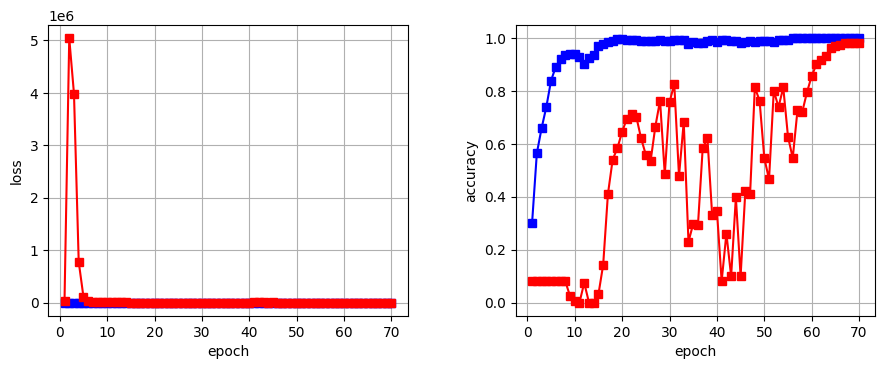

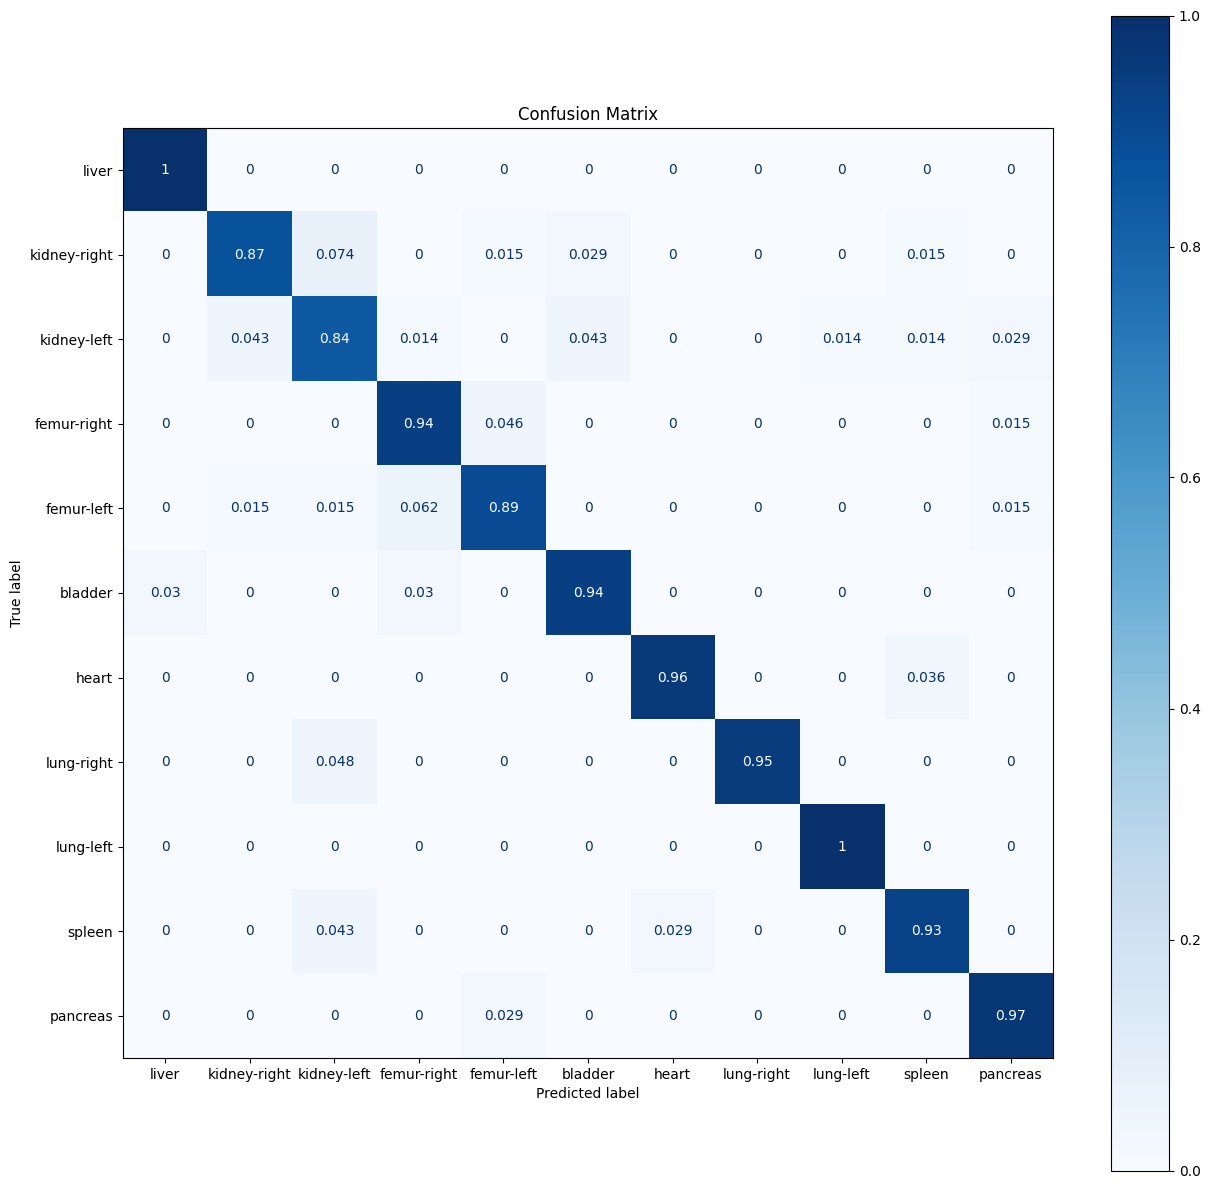

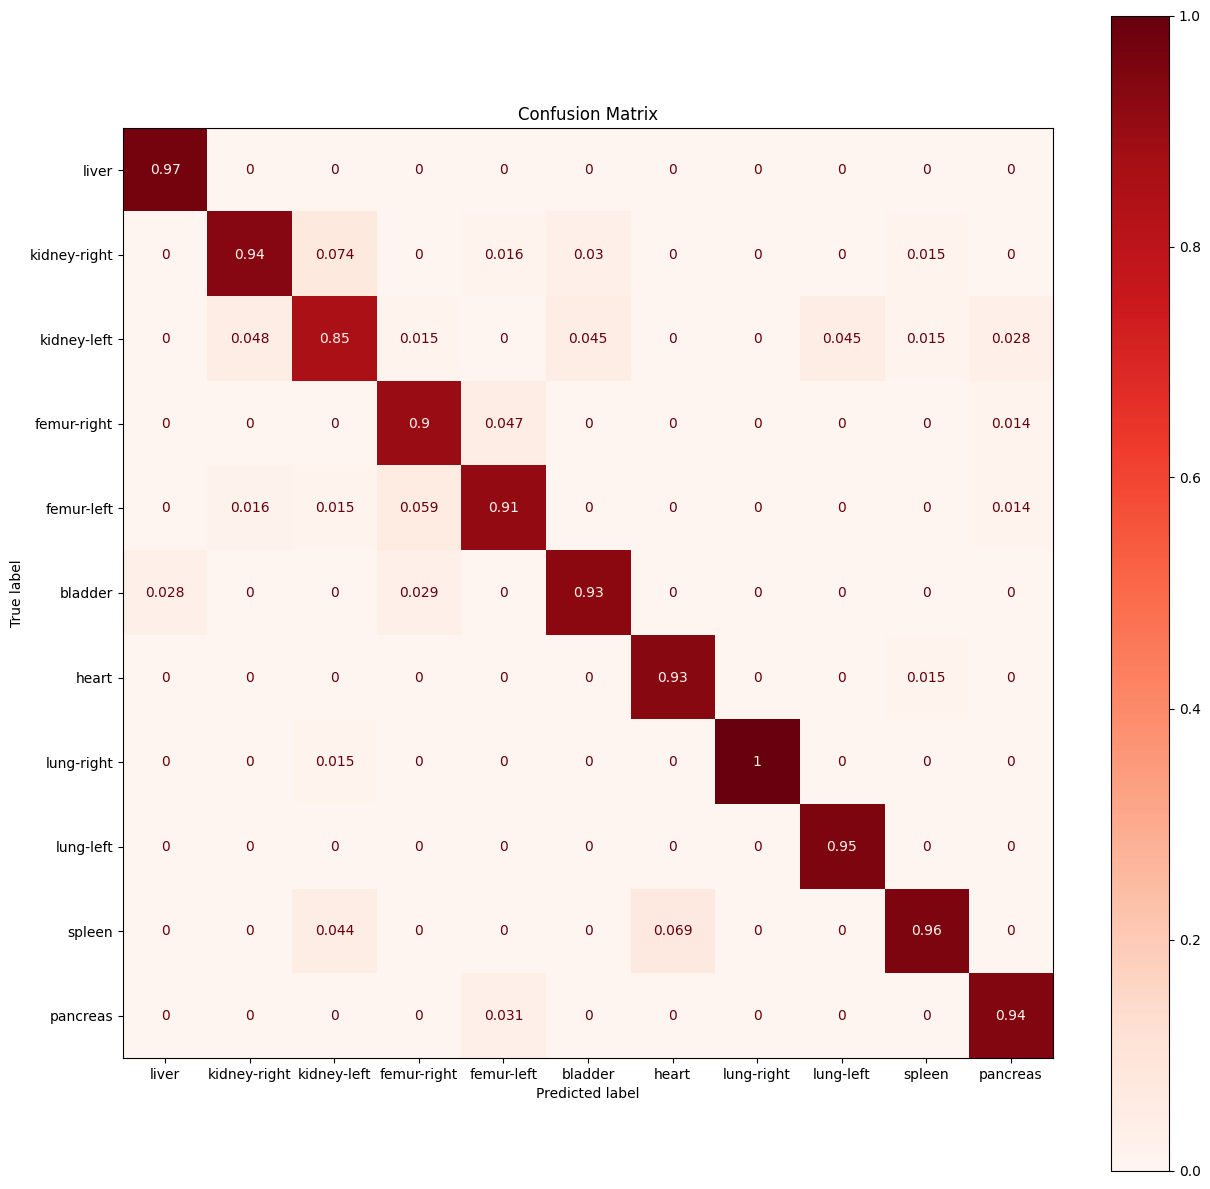

In [18]:
M = MyHyperModel()
model = M.build()
H = M.fit(model,X_train, y_train, (X_val, y_val), verbose=1)

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');

print_cm(model)

score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Consigue un 92.79% de acierto, imponiéndose a todos los modelos publicados hasta la fecha.